# PPCA in PyStan - Part 2: Setting up the PyStan environment
In part 1, we managed to reproduce $x$ with our PPCA model in PyStan, but the estimates of our parameters were not accurate. Specifically, we ended up with a latent dataset $z$ in which all points were close to zero. In part 2, we will try to approach the true values of these values more accurately.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

## indentifying the problem

Suppose we have a model in PyStan in which the prior over $z$ is specified. Let's take a look at the outcome of our estimates.

In [2]:
prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

transformed parameters{
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    //  likelihood
    for (n in 1:N){
        z[:,n] ~ multi_normal(mean_z,cov_z);
        x[n] ~ normal(W*col(z,n), sigma);
    }
}
"""
ppca_pystan_prior = pystan.StanModel(model_code=prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f17b874e960d078f537ca188372ff26e NOW.


We specify our parameters and generate some data.

In [3]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

And then we can optimize our parameters and latent dataset.

In [4]:
op_prior = ppca_pystan_prior.optimizing(data=ppca_dat)

z_p = op_prior['z']
sigma_p = op_prior['sigma']
W_p = op_prior['W']
x_p = np.random.normal(np.matmul(W_p,z_p),sigma_p)

In [5]:
fit = ppca_pystan_prior.sampling(data=ppca_dat, iter=50, chains=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [6]:
np.std(fit.summary()['summary'][:2001,0])

/usr/lib/python3.7/site-packages/pystan/misc.py:366: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


0.7831958974157109

Let's compare our models with the real values and the values as found by Tipping & Bishops PPCA method.

In [7]:
print('real variance: ', sigma**2)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance (prior): ', sigma_p**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real z: ', z)
print('simulated z (prior): ', z_p)
print()
print('real W: ', W)
print('simulated W (prior): ', W_p)
print()

real variance:  1.8579826243671056
simulated variance (prior):  0.6118873346216536

real z:  [[ 0.77517751 -1.38351764  1.43483939 ...  2.19327798 -1.82764013
   1.17000582]
 [ 0.50214974 -0.60126631  1.09451414 ...  0.34278138  0.85564829
   0.3987846 ]]
simulated z (prior):  [[ 0.00653288 -0.00708773  0.00544112 ...  0.00960473 -0.00275516
   0.00319848]
 [ 0.00259111  0.00362986 -0.00752048 ...  0.00087601 -0.00946707
  -0.00332887]]

real W:  [[ 0.23943878 -1.83585796]
 [ 0.92807613  1.15865618]
 [-1.19724022 -0.90121653]]
simulated W (prior):  [[  32.11701972  414.41809604]
 [ 347.40512213    4.2694324 ]
 [-401.71191523  -94.0473749 ]]



We see that the prior over $z$ causes our latent data to be very close to zero, whereas defining no prior leaves us with very large values. According to our model, $z$ is a Gaussian $\mathcal{N}(0,1)$. Let's see what latent distribution our models generate.

In [8]:
print('Model with prior: p(z) = N(z|',np.mean(z_p, axis=1),',',np.std(z_p, axis=1),')')

Model with prior: p(z) = N(z| [ 7.82144535e-05 -1.13273251e-04] , [0.00523886 0.0057957 ] )


Strangely, the model with the specified prior does not produce samples of $z$ according to the given distribution: although the mean is close to zero, the std. dev. is too! This can be explained as follows. PyStan takes only 'parameters' and expected missing data is treated as a parameter as well. PyStan recieves the command to optimize all parameters according to their likelihood. The original PPCA model does not estimate $z$, it merely takes its distribution into account. PyStan, in contrast, optimizes $z$ to its prior. Since $z$ comes from a zero-centered Normal dsitribution, values of $z$ are most likely when close to zero Hence, PyStan generates $N\times M$ estimates of $z$ that are all close to zero. In turn, this is compensated by a $W$ with very large values, which is totally possible as the values of $W$ have flat priors without further restrictions. If we want PyStan to find accurate values for the other parameters, it shall be necessary to eliminate the option to optimize $z$ to its zero-mean.

In [9]:
no_prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

transformed parameters{
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    //  likelihood
    for (n in 1:N){
        x[n] ~ normal(W*col(z,n), sigma);
        z[:,n] ~ multi_normal(mean_z, cov_z);
        }
}
"""
ppca_pystan_no_prior = pystan.StanModel(model_code=no_prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_90c7aae6f5f5d85259d0be6a4bad93ab NOW.


In [10]:
op_no_prior = ppca_pystan_no_prior.optimizing(data=ppca_dat)

z_np = op_no_prior['z']
sigma_np = op_no_prior['sigma']
W_np = op_no_prior['W']
x_np = np.random.normal(np.matmul(W_p,z_p),sigma_np)

In [11]:
print('real variance: ', sigma**2)
print('simulated variance: (no prior)', sigma_np**2)
print()
print('real z: ', z)
print('simulated z (no prior): ', z_np)
print()
print('real W: ', W)
print('simulated W (no prior): ', W_np)
print()

real variance:  1.8579826243671056
simulated variance: (no prior) 0.6122059023143799

real z:  [[ 0.77517751 -1.38351764  1.43483939 ...  2.19327798 -1.82764013
   1.17000582]
 [ 0.50214974 -0.60126631  1.09451414 ...  0.34278138  0.85564829
   0.3987846 ]]
simulated z (no prior):  [[ 0.00607801 -0.00808255  0.00730002 ...  0.00956744 -0.00067196
   0.00399546]
 [ 0.00287952 -0.00834581  0.01024451 ...  0.0066175   0.00558008
   0.00514232]]

real W:  [[ 0.23943878 -1.83585796]
 [ 0.92807613  1.15865618]
 [-1.19724022 -0.90121653]]
simulated W (no prior):  [[ 515.78588103 -654.02488931]
 [ 413.02076313 -112.46813399]
 [-622.12090144  298.22290911]]



We see that the prior over $z$ causes our latent data to be very close to zero, whereas defining no prior leaves us with very large values. According to our model, $z$ is a Gaussian $\mathcal{N}(0,1)$. Let's see what latent distribution our models generate.

In [12]:
print('Model without prior: p(z) = N(z|',np.mean(z_np, axis=1),',',np.std(z_np, axis=1),')')

Model without prior: p(z) = N(z| [0.00010757 0.00015127] , [0.00625271 0.00778785] )


The model without a prior doesn't generate samples that are too close to the mean anymore The sampled values do not adhere to the given distribution either, but that was to be expected since we specified not prior. 
The plots below show that both models manage to reproduce $x$, but with very different latent datasets (note the scale on the axes).

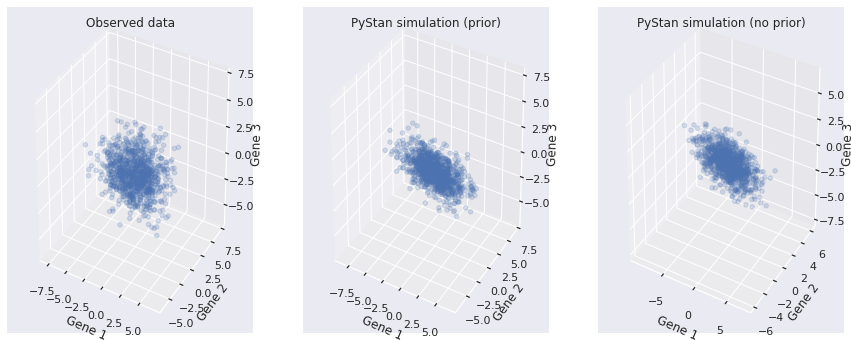

In [13]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_p[0,:],x_p[1,:],x_p[2,:], alpha=0.2)
ax.set_title('PyStan simulation (prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_np[0,:],x_np[1,:],x_np[2,:], alpha=0.2)
ax.set_title('PyStan simulation (no prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

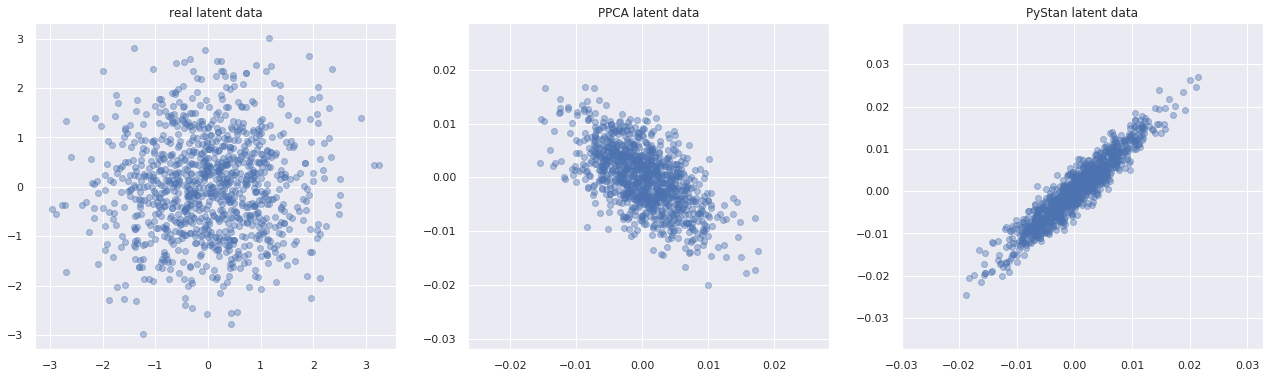

In [14]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_p[0,:], z_p[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_np[0,:], z_np[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

## How does PyStan deal with this?
The [following piece of code](https://mc-stan.org/docs/2_22/stan-users-guide/missing-data.html) is taken from the [Stan Users Guide](https://mc-stan.org/docs/2_22/stan-users-guide/index.html). Let's see how PyStan deals with missing data. The following script is supposed to estimate missing values given a set of observed data, by estimating the mean and standard deviation of the observed data.

In [15]:
missingdata = '''
data {
  int<lower=0> N_obs;
  int<lower=0> N_mis;
  real y_obs[N_obs];
}
parameters {
  real mu;
  real<lower=0> sigma;
  real y_mis[N_mis];
}
model {
  y_obs ~ normal(mu, sigma);
  y_mis ~ normal(mu, sigma);
}
'''
miss = pystan.StanModel(model_code=missingdata)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a20f82b4a27dcf682c721571cfaabdf3 NOW.


In [16]:
info = miss.vb(data=md_dat)

NameError: name 'md_dat' is not defined

In [19]:
import pandas as pd
df = pd.read_csv(info['args']['sample_file'].decode('ascii'), comment='#').dropna()
sdf = df.mean()

NameError: name 'info' is not defined

In [20]:
def extract_alpha(sdf):
    v_a = sdf[sdf.index.str.startswith('sigma.')]
    print(v_a)
    v_a.index = v_a.index.str.extract('sigma\.(\d+)', expand=False).map(int)

    return v_a

alpha = extract_alpha(sdf)
# alpha.index = Y.columns
alpha

NameError: name 'sdf' is not defined

In [21]:
N_obs = 1000
N_mis = 100
a = np.random.normal(5,3,size=N_obs)
md_dat = {'N_obs': N_obs, 'N_mis':N_mis, 'y_obs':a}
op = miss.optimizing(data=md_dat)
y = op['y_mis']

print('First missing values: ', y[:6])
print('Mean of the filled in missing data: ', np.mean(y))
print('Standard deviation of the filled in missing data: ', np.std(y))

First missing values:  [4.98341605 4.98305055 4.98337874 4.9834167  4.98349665 4.9833571 ]
Mean of the filled in missing data:  4.983238583394996
Standard deviation of the filled in missing data:  0.000356588966037287


As we can see, PyStan is perfectly able to estimate the mean and standard deviation of the observed data. However, when finding the values of the missing data, the scipt doesn't generate values that follow the found distribution, but attempts to return values with the highest likelihood. This is the same problem we encounter in our PPCA problem. It looks like we need a differrent approach than using the 'optimizing()'-method to obtain point estimates. The 'sampling()'-method might be more suitable. This method generates multiple samples, we use the sample with the highest likelihood. This is very unlikely to be the precise *maximum* likelihood, it is just the most likely set of parameters that we happened to have sampled.

In [22]:
fit = miss.sampling(data = md_dat, iter=100, chains=1)
b = fit.extract()

best_ind = np.where(b['lp__']==max(b['lp__']))[0][0]

[]

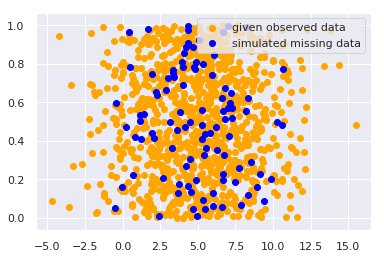

In [23]:
plt.scatter(a, np.random.uniform(size=N_obs), color='orange', label='given observed data')
plt.scatter(b['y_mis'][best_ind,:], np.random.uniform(size=N_mis), color='blue', label='simulated missing data')
plt.legend()
plt.plot()

This works better, we generate samples for each of the 100 missing datapoints and they are generated from the right distribution.

In [24]:
print('mean standard deviation of best sample: ', np.std(b['y_mis'][best_ind]))
print('mean average of best sample: ', np.mean(b['y_mis'][best_ind,:]))

mean standard deviation of best sample:  2.5641262425641824
mean average of best sample:  4.940248411149523


### Applying our solution to the latent variable model

Now we apply this method to the latent variable model. We generate multiple samples and take the average of all samples of $\sigma$ and $W$ as our best guess, but for $z$ we should not do this, as the mean of all guesses will just converge back to the mean of $z$.

In [25]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

In [ ]:
fit = ppca_pystan_prior.sampling(data=ppca_dat, iter=200, chains=1)
fitreturn = fit.extract()
best_ind = np.where(fitreturn['lp__']==max(fitreturn['lp__']))[0][0]

In [ ]:
ppca = PPCA()
ppca.fit(x.T, mu = np.zeros(D)[np.newaxis].T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]

In [ ]:
print('Real sigma: ', sigma)
print('PyStan sigma', fitreturn['sigma'][best_ind])
print('PPCA sigma: ', np.sqrt(sigma_ppca))
print()
print('Real WW^T:\n',np.matmul(W,W.T))
print('PyStan WW^T:\n',np.matmul(fitreturn['W'][best_ind],fitreturn['W'][best_ind].T))
print('PPCA WW^T:\n', np.matmul(W_ppca,W_ppca.T))

As we can see, the sampled $\sigma$ is almost equal to the actual $\sigma$, and the sampled $W$ is almost a perfect rotation of the actual $W$.
 We can also assure that $z$ follows the correct distribution of $\mathcal{N}(0,1)$.

In [ ]:
print('Average mean of PyStan z: ',np.mean(fitreturn['z'][best_ind], axis=1))
print('Average standard deviation of z: ',np.std(fitreturn['z'][best_ind]))
print()
print('Average mean of PPCA z: ',np.mean(z_ppca, axis=1))
print('Average standard deviation of PPCA z: ',np.std(z_ppca, axis=1))

### Adding $\mu$ again

In [2]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

transformed parameters{
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    //  priors
    //for (d in 1:D){
    //    W[d] ~ normal(0.0,sigma);
    //    mu[d]~normal(0.0, 5.0) ;
    //    }
    //sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N){
        z[:,n] ~ multi_normal(mean_z, cov_z);
        x[n] ~ normal(W*col(z,n)+mu, sigma);
        }
        
}
"""
ppca_pystan_mu = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_992ccee2aeb4b49461977326363edfff NOW.


In [10]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
mu = np.random.normal(0,15,size=(D,1))
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

In [ ]:
fit = ppca_pystan_mu.sampling(data=ppca_dat, iter=200, chains=1)
fitreturn = fit.extract()

best_ind = np.where(fitreturn['lp__']==max(fitreturn['lp__']))[0][0]

Again, we obtain an accurate guess for $\sigma$ and $W$.

In [ ]:
ppca = PPCA()
ppca.fit(x.T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]

In [ ]:
print('Real mu:\n', mu)
print('Sampled mu mean:\n', fitreturn['mu'][best_ind])
print('PPCA mu:\n', mu_ppca)
print()
print('Real sigma: ', sigma)
print('Sampled sigma mean: ', fitreturn['sigma'][best_ind])
print('PPCA sigma: ', np.sqrt(sigma_ppca))
print()
print('Real WW^T:\n',np.matmul(W,W.T))
print('Sampled WW^T:\n',np.matmul(fitreturn['W'][best_ind],fitreturn['W'][best_ind].T))
print('PPCA WW^T:\n', np.matmul(W_ppca,W_ppca.T))


And a well-distributed $\bar{z}$.

In [ ]:
print('Average mean of z (PyStan): ',np.mean(np.mean(fitreturn['z'][best_ind], axis=2), axis=0))
print('Average standard deviation of z (PyStan): ',np.mean(np.std(fitreturn['z'][best_ind], axis=2), axis=0))
print()
print('Average mean of z (PPCA): ',np.mean(z_ppca, axis=1))
print('Average standard deviation of z (PPCA): ',np.std(z_ppca, axis=1))

### Test on Iris dataset
Lets apply our algorithm on some sample data as a test!

In [5]:
from sklearn import datasets
iris = datasets.load_iris()
iris_x = iris.data
iris_y = iris.target

In [17]:
iris_dat = {'N': 150, 'D':4, 'M':2, 'x':np.array(iris_x)}

irisfit = ppca_pystan_mu.sampling(data=iris_dat, iter=200, chains=1)
iris_fitreturn = irisfit.extract()

best_ind = np.where(iris_fitreturn['lp__']==max(iris_fitreturn['lp__']))[0][0]
latent_data = iris_fitreturn['z'][best_ind]

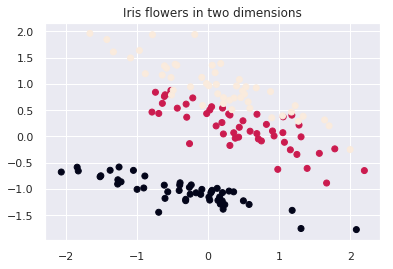

In [29]:
plt.scatter(latent_data[0,:], latent_data[1,:], c=iris_y)
plt.title('Iris flowers in two dimensions')
plt.show()

Beautiful!